850-hPa Geopotential Heights, Temperature, Frontogenesis, and Winds
===================================================================

Frontogenesis at 850-hPa with Geopotential Heights, Temperature, and
Winds

This example uses example data from the GFS analysis for 12 UTC 26
October 2010 and uses xarray as the main read source with using MetPy to
calculate frontogenesis and wind speed with geographic plotting using
Cartopy for a CONUS view.


Import the needed modules.


In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr

Use Xarray to access GFS data from THREDDS resource and uses
metpy accessor to parse file to make it easy to pull data using
common coordinate names (e.g., vertical) and attach units.


In [2]:
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/'
                     'python-gallery/GFS_20101026_1200.nc').metpy.parse_cf()

Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Proje

Subset data based on latitude and longitude values, calculate potential
temperature for frontogenesis calculation.


In [3]:
# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(200, 350)
lat_slice = slice(85, 10)

# Grab lat/lon values (GFS will be 1D)
lats = ds.lat.sel(lat=lat_slice).values
lons = ds.lon.sel(lon=lon_slice).values

level = 850 * units.hPa
hght_850 = ds.Geopotential_height_isobaric.metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).metpy.unit_array.squeeze()
tmpk_850 = ds.Temperature_isobaric.metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).metpy.unit_array.squeeze()
uwnd_850 = ds['u-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).metpy.unit_array.squeeze()
vwnd_850 = ds['v-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).metpy.unit_array.squeeze()

# Convert temperatures to degree Celsius for plotting purposes
tmpc_850 = tmpk_850.to('degC')

# Calculate potential temperature for frontogenesis calculation
thta_850 = mpcalc.potential_temperature(level, tmpk_850)

# Get a sensible datetime format
vtime = ds.time.data[0].astype('datetime64[ms]').astype('O')

Calculate frontogenesis
-----------------------

Frontogenesis calculation in MetPy requires temperature, wind
components, and grid spacings. First compute the grid deltas using MetPy
functionality, then put it all together in the frontogenesis function.

Note: MetPy will give the output with SI units, but typically
frontogenesis (read: GEMPAK) output this variable with units of K per
100 km per 3 h; a conversion factor is included here to use at plot time
to reflect those units.


In [4]:
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

fronto_850 = mpcalc.frontogenesis(thta_850, uwnd_850, vwnd_850, dx, dy, dim_order='yx')

# A conversion factor to get frontogensis units of K per 100 km per 3 h
convert_to_per_100km_3h = 1000*100*3600*3

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/pint/quantity.py:1236: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Plotting Frontogenesis
----------------------

Using a Lambert Conformal projection from Cartopy to plot 850-hPa
variables including frontogenesis.


Text(1.0, 1.0, 'Valid Time: 2010-10-26 12:00:00')

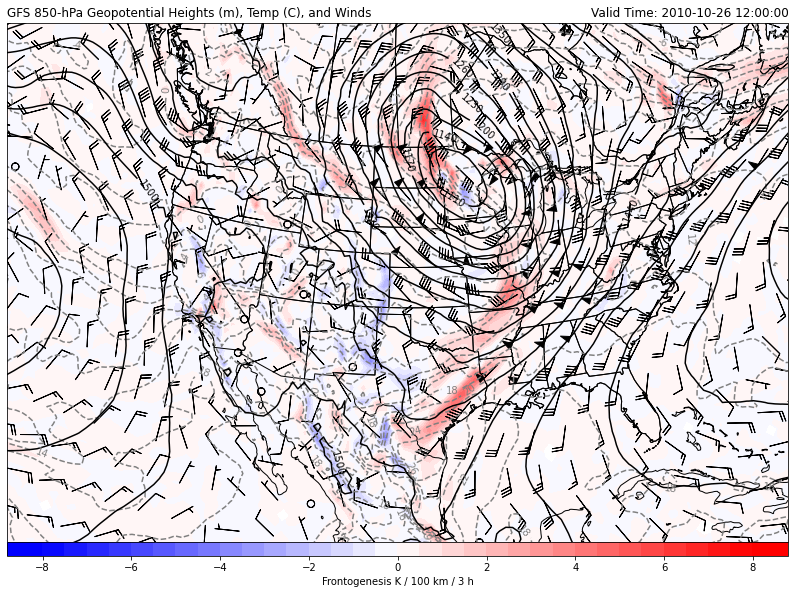

In [5]:
# Set map projection
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set projection of the data (GFS is lat/lon)
datacrs = ccrs.PlateCarree()

# Start figure and limit the graphical area extent
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add map features of Coastlines and States
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 850-hPa Frontogenesis
clevs_tmpc = np.arange(-40, 41, 2)
cf = ax.contourf(lons, lats, fronto_850*convert_to_per_100km_3h, np.arange(-8, 8.5, 0.5),
                 cmap=plt.cm.bwr, extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)
cb.set_label('Frontogenesis K / 100 km / 3 h')

# Plot 850-hPa Temperature in Celsius
csf = ax.contour(lons, lats, tmpc_850, clevs_tmpc, colors='grey',
                 linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

# Plot 850-hPa Geopotential Heights
clevs_850_hght = np.arange(0, 8000, 30)
cs = ax.contour(lons, lats, hght_850, clevs_850_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 850-hPa Wind Barbs only plotting every fifth barb
wind_slice = (slice(None, None, 5), slice(None, None, 5))
ax.barbs(lons[wind_slice[0]], lats[wind_slice[1]],
         uwnd_850[wind_slice].to('kt').m, vwnd_850[wind_slice].to('kt').m,
         color='black', transform=datacrs)

# Plot some titles
plt.title('GFS 850-hPa Geopotential Heights (m), Temp (C), and Winds', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')